## Import Packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import ybus_estimation as ye
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import warnings
from auxiliary import synthesize_data, aggregate_data, synthesize_angle, ybus_calculation, aggregate_sequences, make_bars, discard_data_points, set_box_color, local_copy_from_switch

In [2]:
local_copy_from_switch()

## Settings

In [2]:
databases = {
    0: {'name': 'Enr temps court 2020.10.30', 'phase': ['L2', 'L3']},
    1: {'name': 'Enr temps court 2021.03.04', 'phase': ['L2', 'L3']},
    2: {'name': 'Enr temps court 2021.03.05', 'phase': ['L2', 'L3']},
    3: {'name': 'Enr temps court 2021.03.10', 'phase': ['L2', 'L3']},
    4: {'name': 'Enr temps court 2021.03.11', 'phase': ['L2', 'L3']},
    5: {'name': 'Enr temps court 2021.03.12', 'phase': ['L2', 'L3']},
    6: {'name': 'Enr temps court 2021.03.26 sans GridEye', 'phase': ['L1', 'L2', 'L3']},
    7: {'name': 'Enr temps court 2021.05.28', 'phase': ['L1', 'L2', 'L3']},
    8: {'name': 'Enr temps court 2021.05.31', 'phase': ['L1', 'L2', 'L3']}
}
databases = {key: databases[key] for key in [0, 1, 2, 3, 4, 5, 6, 7, 8]}

resample_period = '1min'

node_a = ['Noeud 1:1', 'Ligne 1', 'Noeud 1:1', 'Ligne 5', 'Ligne 6', 'Ligne 7']
node_b = ['Ligne 1', 'Ligne 2', 'Ligne 5', 'Ligne 6', 'Ligne 7', 'Ligne 8']
r_re = [0.0862154566, 0.0639930, 0.08662527843, 0.1089443835, 0.0479755, 0.1087854744]
x_re = [0.07363, 0.063225, 0.06149552, 0.0745192, 0.0646061623, 0.071606]

vbase=240
sbase=10000
zbase = vbase ** 2 / sbase
max_h = 0.001

incidence, ybus, nodes = ybus_calculation(node_a, node_b, r_re, x_re)

cwd = os.getcwd()
random_number = 1000
np.random.seed(random_number)
random.seed(random_number)

plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2.0

## Load data

In [3]:
df = {}
for i in databases.keys():
    df[i] = pd.DataFrame([])
    df[i] = pd.read_csv(cwd + '/data/' + databases[i]['name'] + '.txt', delimiter = '\t')
    df[i]['Temps'] = pd.to_datetime(df[i]['Temps'], dayfirst= True)
    df[i] = df[i].set_index('Temps')
    df[i] = df[i].resample(resample_period).mean()

## Synthetic Data

### PMU based

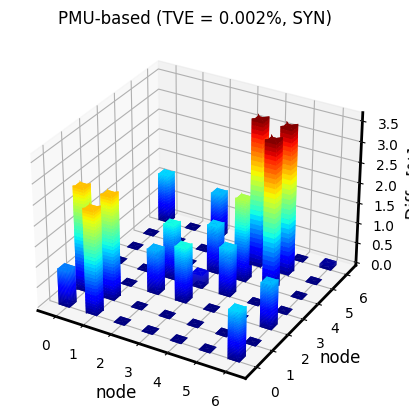

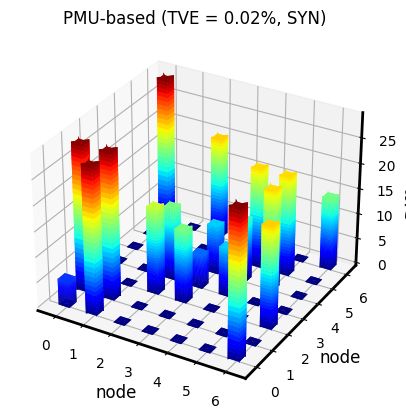

In [4]:
tve_s = [0.002 / 100, 0.02 / 100]
for i, tve in enumerate(tve_s):
    output = []
    for l0 in range(0, len(node_a)):
        node_a0, node_b0 = node_a[l0], node_b[l0]
        aggregated_data = aggregate_data(databases, node_a0, node_b0, df, vbase, sbase)
        synthesized_data = synthesize_angle(aggregated_data, r_re[l0], x_re[l0], vbase, sbase, vn_std=tve, pn_std=0.01, qn_std=0.01, cn_std=0.001, dn_std=tve)
        p2, q2, c2, v2, v1, d1 = [synthesized_data['pj'], synthesized_data['qj'], synthesized_data['cj'], synthesized_data['vj'], synthesized_data['vi'], synthesized_data['di']]
        z = (- v2 + v1 * np.cos(d1 * np.pi /180) + v1 * np.sin(d1 * np.pi /180) * 1j) * (v2 * zbase) / (p2 - q2 * 1j)
        output.append( [node_a0, node_b0, np.real(np.mean(z)), np.imag(np.mean(z)), r_re[l0], x_re[l0], np.abs(np.real(np.mean(z)) - r_re[l0]) * 100 / r_re[l0] + np.abs(np.imag(np.mean(z)) - x_re[l0]) * 100 / x_re[l0]])
    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])

    incidence, ybus2, nodes = ybus_calculation(node_a, node_b, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())

    data = np.abs(ybus2-ybus) * 100/ (np.abs(ybus) + 1e-30)
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1 , 1, projection='3d')
    make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
    ax.set_xlabel("node", fontsize=12)
    ax.set_ylabel("node", fontsize=12)
    ax.set_zlabel("Diff.  [%]", fontsize=12)
    ax.set_zlim(0, np.max([max_h, np.max(data)]))
    plt.title("PMU-based (TVE = " + str(tve * 100) + "%, SYN)", fontsize=12)
    fig.savefig("figures/pmu_based_tve_" + str(tve * 100).replace("0.","") + ".pdf", bbox_inches=mpl.transforms.Bbox.from_bounds(1.6, 0.45, 4, 4))


#### Estimation Matrix Algorithm

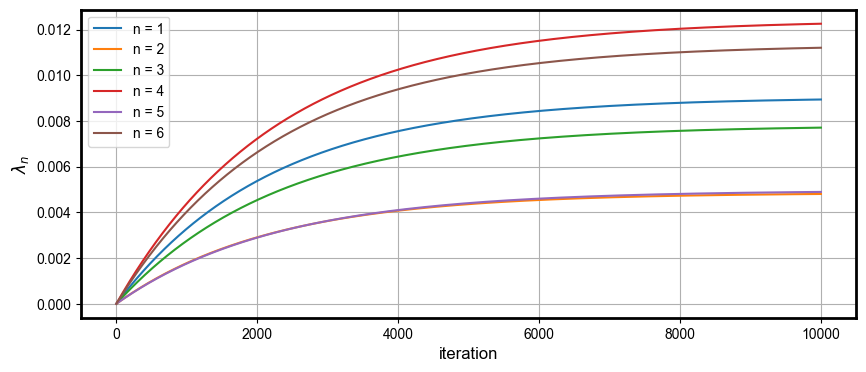

       nodeA    nodeB   R [ohm]   X [ohm]  error [%]  R_re [ohm]  X_re [ohm]  diff [%]
0  Noeud 1:1  Ligne 1  0.086307  0.073520   2.354790    0.086215    0.073630  0.255221
1    Ligne 1  Ligne 2  0.064068  0.062998   1.924925    0.063993    0.063225  0.475319
2  Noeud 1:1  Ligne 5  0.086728  0.061385   2.635792    0.086625    0.061496  0.298534
3    Ligne 5  Ligne 6  0.109100  0.074402   2.696747    0.108944    0.074519  0.299550
4    Ligne 6  Ligne 7  0.047994  0.064475   2.847306    0.047975    0.064606  0.240691
5    Ligne 7  Ligne 8  0.108930  0.071497   2.473548    0.108785    0.071606  0.285632


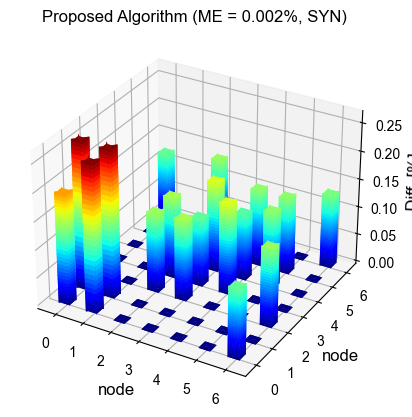

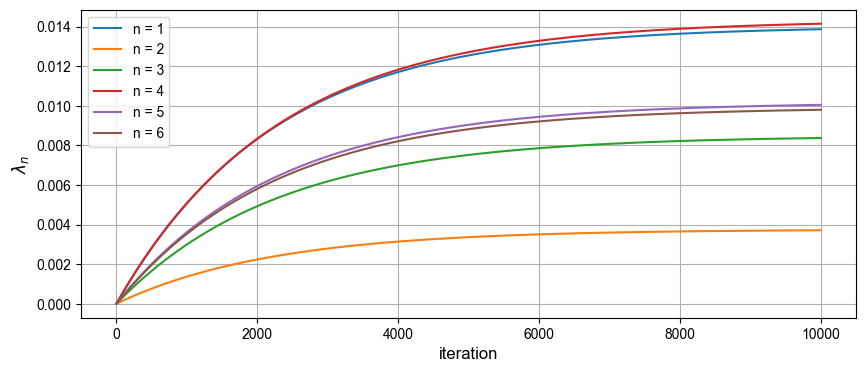

       nodeA    nodeB   R [ohm]   X [ohm]  error [%]  R_re [ohm]  X_re [ohm]  diff [%]
0  Noeud 1:1  Ligne 1  0.086338  0.073861   3.740195    0.086215    0.073630  0.454899
1    Ligne 1  Ligne 2  0.063929  0.062104   1.551948    0.063993    0.063225  1.873307
2  Noeud 1:1  Ligne 5  0.086914  0.061403   2.875829    0.086625    0.061496  0.483490
3    Ligne 5  Ligne 6  0.108954  0.074286   3.137538    0.108944    0.074519  0.321570
4    Ligne 6  Ligne 7  0.047943  0.063897   6.119957    0.047975    0.064606  1.166157
5    Ligne 7  Ligne 8  0.109256  0.071299   2.142334    0.108785    0.071606  0.861759


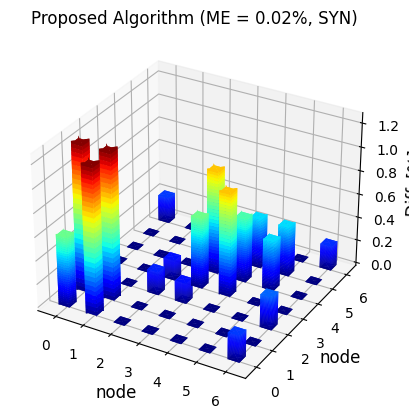

In [5]:
for i, tve in enumerate(tve_s):
    output = []
    plt.figure(figsize=(10, 4))
    for l0 in range(0, len(node_a)):
        node_a0, node_b0 = node_a[l0], node_b[l0]
        aggregated_data = aggregate_data(databases, node_a0, node_b0, df, vbase, sbase)
        synthesized_data = synthesize_angle(aggregated_data, r_re[l0], x_re[l0], vbase, sbase, vn_std=tve, pn_std=0.01, qn_std=0.01, cn_std=0.01, dn_std=tve)
        theta, lam = ye.matrix_algorithm(synthesized_data, vbase, sbase, iter_num=10000, tau=5e-3)
        output.append([node_a0, node_b0, theta[0][0], theta[1][0], 100 * (theta[0][0] ** 2 + theta[1][0] ** 2 - theta[2][0]) / theta[2][0], r_re[l0], x_re[l0], np.abs(theta[0][0] - r_re[l0]) * 100 / r_re[l0] + np.abs(theta[1][0] - x_re[l0]) * 100 / x_re[l0]])
        plt.plot(lam)
    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'error [%]', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])
    plt.legend(["n = " + str(i+1) for i in [*range(8)]])
    plt.style.use('seaborn-v0_8')
    plt.grid(True)
    plt.xlabel("iteration", fontsize=12)
    plt.ylabel("$\lambda_n$", fontsize=12)
    plt.savefig("figures/convergence_lambda_syn_" + str(tve * 100).replace("0.", "") + ".pdf")

    plt.show()
    plt.style.use('default')
    incidence, ybus2, nodes = ybus_calculation(node_a, node_b, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())

    data= np.abs(ybus2 - ybus) * 100/ (np.abs(ybus) + 1e-30)
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
    ax.set_xlabel("node", fontsize=12)
    ax.set_ylabel("node", fontsize=12)
    ax.set_zlabel("Diff. [%]", fontsize=12)
    ax.set_zlim(0, np.max([max_h, np.max(data)]))
    plt.title("Proposed Algorithm (ME = " + str(tve * 100) + "%, SYN)", fontsize=12)
    fig.savefig("figures/matrix_estimation_algorithm_syn_me_" + str(tve * 100).replace("0.","") + ".pdf", bbox_inches=mpl.transforms.Bbox.from_bounds(1.6, 0.45, 4, 4))
    print(result.to_string())

#### Minimization Algorithm

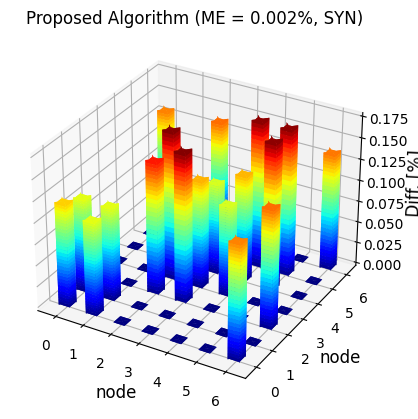

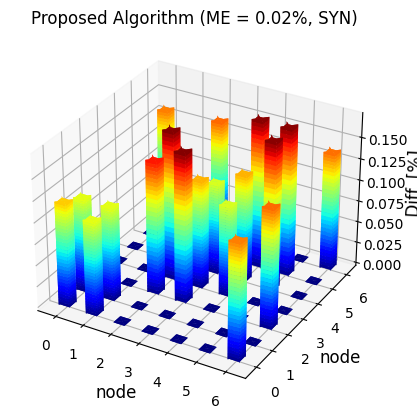

ValueError: operands could not be broadcast together with shapes (7,7) (5,5) 

In [10]:
for i, tve in enumerate(tve_s):
    output = []
    for l0 in range(0, len(node_a)):
        node_a0, node_b0 = node_a[l0], node_b[l0]
        aggregated_data = aggregate_data(databases, node_a0, node_b0, df, vbase, sbase)
        synthesized_data = synthesize_data(aggregated_data, r_re[l0], x_re[l0], vbase, sbase, vn_std=0.00, pn_std=0.0, qn_std=0.0, cn_std=0.00)
        r, x, std_r, std_x, z, error_z, r_clean, x_clean, z_clean  = ye.minimization_algorithm(synthesized_data, vbase, sbase, n_tests=500, n_sample=4000, epsilon=0)
        output.append([node_a0, node_b0, r, x, std_r, std_x, z, error_z, r_re[l0], x_re[l0], np.abs(r - r_re[l0]) * 100 / r_re[l0] + np.abs(x - x_re[l0]) * 100 / x_re[l0]])
    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'std_R [ohm]', 'std_X [ohm]', 'Z', 'error_Z', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])

    plt.style.use('default')
    incidence, ybus2, nodes = ybus_calculation(node_a, node_b, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())

    data= np.abs(ybus2 - ybus) * 100/ (np.abs(ybus) + 1e-30)
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
    ax.set_xlabel("node", fontsize=12)
    ax.set_ylabel("node", fontsize=12)
    ax.set_zlabel("Diff. [%]", fontsize=12)
    ax.set_zlim(0, np.max([max_h, np.max(data)]))
    plt.title("Proposed Algorithm (ME = " + str(tve * 100) + "%, SYN)", fontsize=12)
    fig.savefig("figures/minimization_algorithm_syn_me_" + str(tve * 100).replace("0.","") + ".pdf", bbox_inches=mpl.transforms.Bbox.from_bounds(1.6, 0.45, 4, 4))

## Laboratory Data

#### Estimation Matrix Algorithm

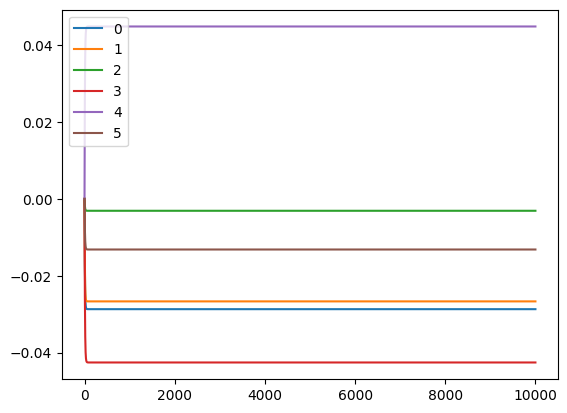

       nodeA    nodeB   R [ohm]   X [ohm]     error [%]  R_re [ohm]  X_re [ohm]   diff [%]
0  Noeud 1:1  Ligne 1  0.078015  0.072282 -9.048635e-13    0.086215    0.073630  11.343019
1    Ligne 1  Ligne 2  0.061322  0.064360 -1.448794e-12    0.063993    0.063225   5.969964
2  Noeud 1:1  Ligne 5  0.084913  0.069093  6.079636e-13    0.086625    0.061496  14.330607
3    Ligne 5  Ligne 6  0.106456  0.076334 -3.639357e-13    0.108944    0.074519   4.719067
4    Ligne 6  Ligne 7  0.052163  0.062000 -5.945333e-13    0.047975    0.064606  12.761788
5    Ligne 7  Ligne 8  0.108647  0.072175 -1.916894e-12    0.108785    0.071606   0.921177


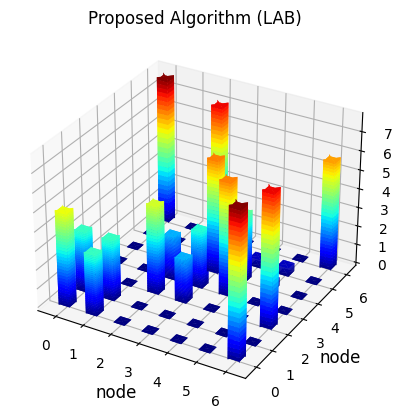

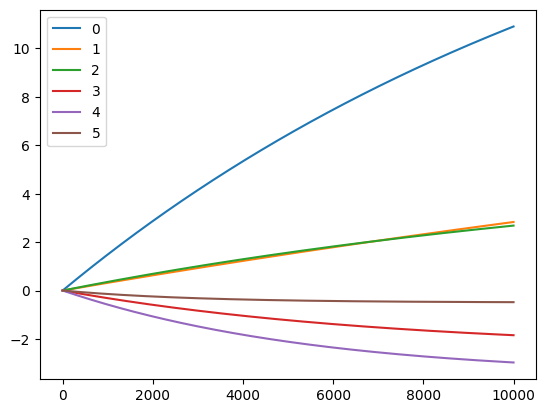

       nodeA    nodeB   R [ohm]   X [ohm]   error [%]  R_re [ohm]  X_re [ohm]    diff [%]
0  Noeud 1:1  Ligne 1 -0.064573  0.094199 -136.150836    0.086215    0.073630  202.833099
1    Ligne 1  Ligne 2 -0.095266  0.054639 -379.921487    0.063993    0.063225  262.449988
2  Noeud 1:1  Ligne 5 -0.086751  0.085759  519.174148    0.086625    0.061496  239.600491
3    Ligne 5  Ligne 6 -0.067557  0.087207  -31.883090    0.108944    0.074519  179.036704
4    Ligne 6  Ligne 7 -0.004011  0.093752  -43.834539    0.047975    0.064606  153.473733
5    Ligne 7  Ligne 8 -0.166119  0.036680   -1.242295    0.108785    0.071606  301.478790


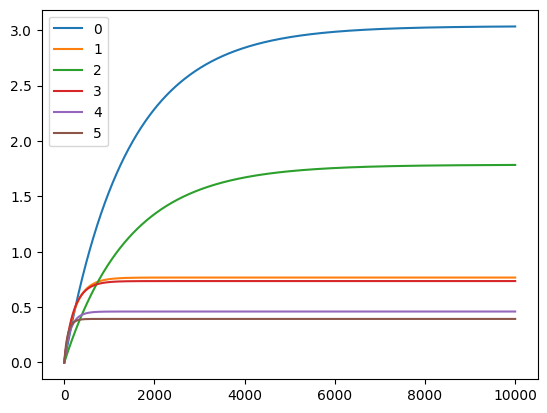

       nodeA    nodeB   R [ohm]   X [ohm]     error [%]  R_re [ohm]  X_re [ohm]    diff [%]
0  Noeud 1:1  Ligne 1  0.116714  0.076535  8.248953e-01    0.086215    0.073630   39.319291
1    Ligne 1  Ligne 2  0.085870  0.079815  2.464996e-11    0.063993    0.063225   60.426214
2  Noeud 1:1  Ligne 5  0.116549  0.081286  4.503092e-01    0.086625    0.061496   66.725538
3    Ligne 5  Ligne 6  0.113234  0.079096  1.871289e-11    0.108944    0.074519   10.079442
4    Ligne 6  Ligne 7  0.087143  0.078713  1.017709e-11    0.047975    0.064606  103.476554
5    Ligne 7  Ligne 8  0.021716  0.138642  6.095689e-12    0.108785    0.071606  173.655476


In [ ]:
for seq in ["pos", "neg", "zero"]:
    plt.figure()
    output = []
    for l0 in range(0, len(node_a)):
        node_a0, node_b0 = node_a[l0], node_b[l0]
        aggregated_data = aggregate_sequences(databases, node_a0, node_b0, df, vbase, sbase, seq=seq)
        theta, lam = ye.matrix_algorithm(aggregated_data, vbase, sbase, iter_num=10000, tau=5e-1)
        output.append(
            [node_a0, node_b0, theta[0][0], theta[1][0],
             100 * (theta[0][0] ** 2 + theta[1][0] ** 2 - theta[2][0]) / theta[2][0], r_re[l0], x_re[l0],
             np.abs(theta[0][0] - r_re[l0]) * 100 / r_re[l0] + np.abs(theta[1][0] - x_re[l0]) * 100 / x_re[l0]])
        plt.plot(lam)
    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'error [%]', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])
    plt.legend([*range(8)])
    plt.show()
    print(result.to_string())
    plt.style.use('default')
    incidence, ybus2, nodes = ybus_calculation(node_a, node_b, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())
    if seq == "pos":
        data= np.abs(ybus2 - ybus) * 100/ (np.abs(ybus) + 1e-30)
        x = np.arange(data.shape[1])
        y = np.arange(data.shape[0])
        x_mesh, y_mesh = np.meshgrid(x, y)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
        ax.set_xlabel("node", fontsize=12)
        ax.set_ylabel("node", fontsize=12)
        ax.set_zlabel("Diff. [%]", fontsize=12)
        ax.set_zlim(0, np.max([max_h, np.max(data)]))
        plt.title("Proposed Algorithm (LAB)", fontsize=12)
        fig.savefig("figures/matrix_estimation_algorithm_lab_" + seq + ".pdf", pad_inches = 0, bbox_inches='tight')

#### Minimization Algorithm

       nodeA    nodeB   R [ohm]   X [ohm]  std_R [ohm]  std_X [ohm]         Z       error_Z  R_re [ohm]  X_re [ohm]     diff [%]
0  Noeud 1:1  Ligne 1  0.140320  0.092841     0.000772     0.000553  0.028339 -1.627501e-10    0.105626    0.059888    87.871649
1    Ligne 1  Ligne 2  0.107820  0.084515     0.000711     0.000563  0.018795 -2.351123e-10    0.083086    0.063427    63.015534
2  Noeud 1:1  Ligne 5  0.146511  0.095095     0.000717     0.000413  0.030531 -2.388167e-10    0.039912    0.061692   321.226897
3    Ligne 5  Ligne 6  0.162889  0.077625     0.001000     0.000582  0.032603 -1.186612e-10    0.042638    0.109149   310.909343
4    Ligne 6  Ligne 7  0.365332  0.051587     0.060406     0.006478  0.258581  8.066361e-09    0.040983    0.043179   810.887769
5    Ligne 7  Ligne 8  0.719312  0.054613     0.085776     0.013346  0.770409  5.789584e-10    0.040103    0.108991  1743.533228
       nodeA    nodeB   R [ohm]   X [ohm]  std_R [ohm]  std_X [ohm]         Z       error_Z  R_re

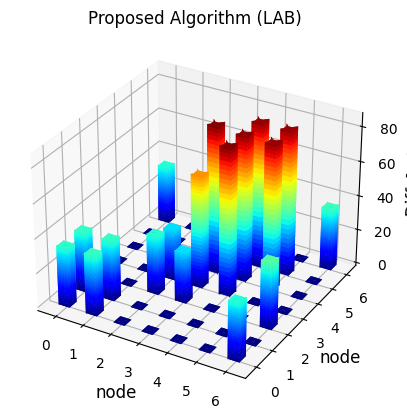

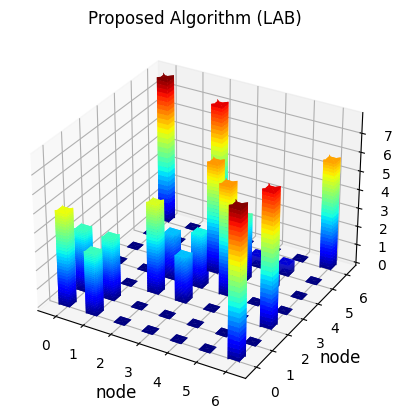

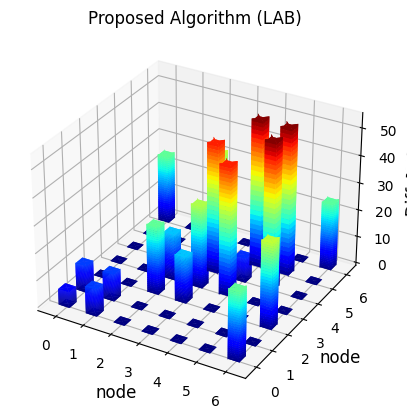

In [ ]:
for seq in ["zero", "pos", "neg"]:
    r_re0 = [0.105626258, 0.083086315, 0.039912224, 0.042637909, 0.04098344, 0.040103482] if seq == "zero" else r_re
    x_re0 = [0.059887576, 0.063427397, 0.061692337, 0.109148685, 0.043178868, 0.108990898] if seq == "zero" else x_re
    incidence, ybus, nodes = ybus_calculation(node_a, node_b, r_re, x_re)
    output = []
    zbase = vbase ** 2 / sbase
    for l0 in range(0, len(node_a)):
        node_a0, node_b0 = node_a[l0], node_b[l0]
        aggregated_data = aggregate_sequences(databases, node_a0, node_b0, df, vbase, sbase, seq=seq)
        r, x, std_r, std_x, z, error_z, r_clean, x_clean, z_clean  = ye.minimization_algorithm(aggregated_data, vbase, sbase, n_tests=500, n_sample=4000, seq=seq)
        output.append([node_a0, node_b0, r, x, std_r, std_x, z, error_z, r_re0[l0], x_re0[l0], np.abs(r - r_re0[l0]) * 100 / r_re0[l0] + np.abs(x - x_re0[l0]) * 100 / x_re0[l0]])
    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'std_R [ohm]', 'std_X [ohm]', 'Z', 'error_Z', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])

    print(result.to_string())
    plt.style.use('default')
    incidence, ybus2, nodes = ybus_calculation(node_a, node_b, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())
    data= np.abs(ybus2 - ybus) * 100 / (np.abs(ybus) + 1e-30)
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    x_mesh, y_mesh = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
    ax.set_xlabel("node", fontsize=12)
    ax.set_ylabel("node", fontsize=12)
    ax.set_zlabel("Diff. [%]", fontsize=12)
    ax.set_zlim(0, np.max([max_h, np.max(data)]))
    plt.title("Proposed Algorithm (LAB)", fontsize=12)
    fig.savefig("figures/minimization_algorithm_lab_" + seq + ".pdf", bbox_inches=mpl.transforms.Bbox.from_bounds(1.6, 0.45, 4, 4))

## Actual data

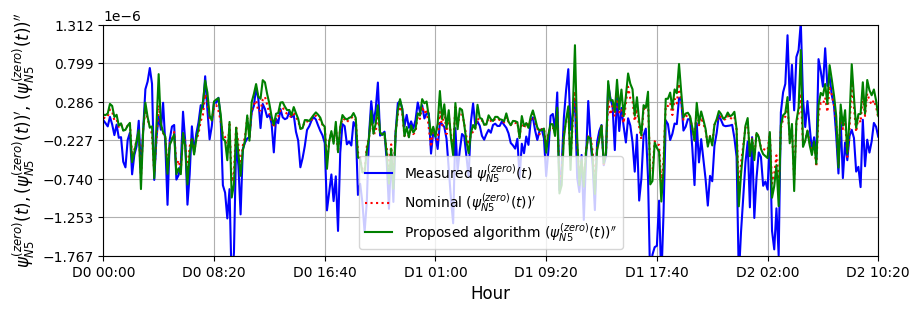

delta proposed: 2.9797337951215745e-07
delta nominal: 2.871271444785774e-07
Ratio of difference m: 1.0377750249050008


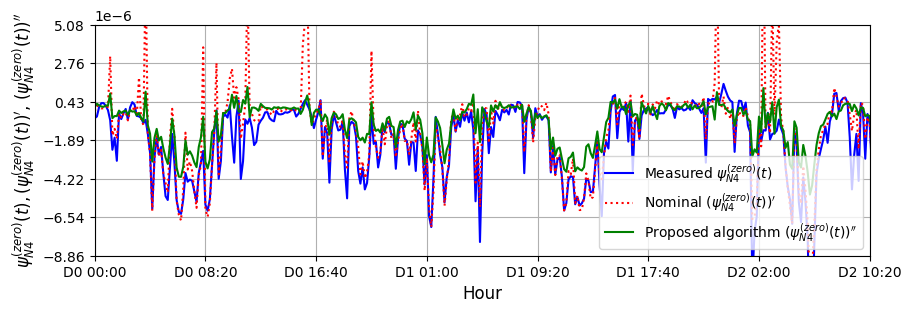

delta proposed: 1.1589487891863626e-06
delta nominal: 8.422678617658352e-07
Ratio of difference m: 1.3759860037359115


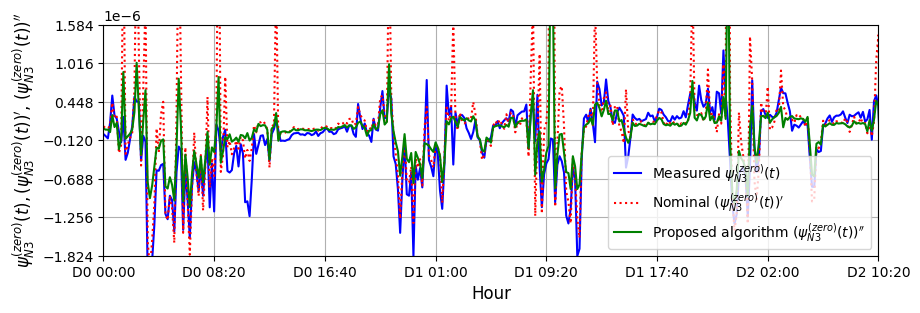

delta proposed: 2.468167004400541e-07
delta nominal: 3.7198199170388215e-07
Ratio of difference m: 0.663517874372084


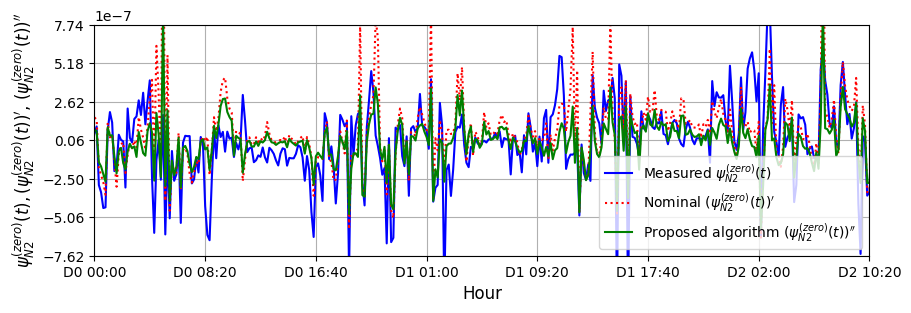

delta proposed: 1.3582249298165202e-07
delta nominal: 1.5168679087382728e-07
Ratio of difference m: 0.8954141108742214
  nodeA nodeB   R [ohm]   X [ohm]  std_R [ohm]  std_X [ohm]         Z       error_Z  R_re [ohm]  X_re [ohm]    diff [%]
0   100   104  0.017802  0.009438     0.000081     0.000019  0.000406 -5.236656e-08       0.014       0.006   84.450225
1   100   103  0.025087  0.034978     0.000195     0.000082  0.001854 -5.853187e-09       0.078       0.024  113.579042
2   101   102  0.016970  0.013917     0.000057     0.000035  0.000482 -9.301541e-08       0.038       0.012   71.319546
3   100   101  0.017572  0.009404     0.000058     0.000023  0.000397 -9.692140e-08       0.021       0.016   57.553954


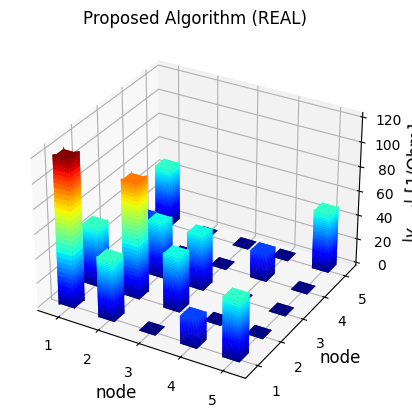

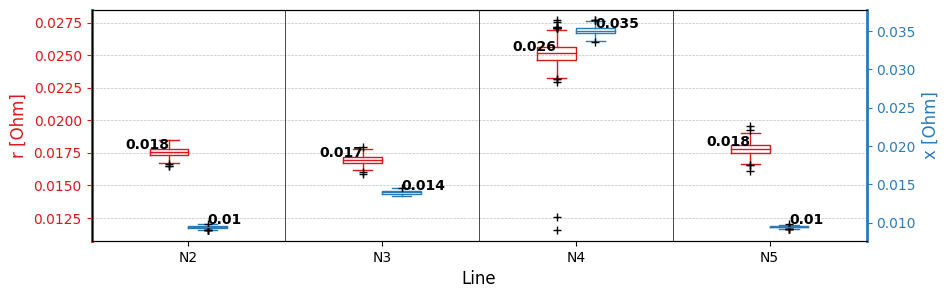

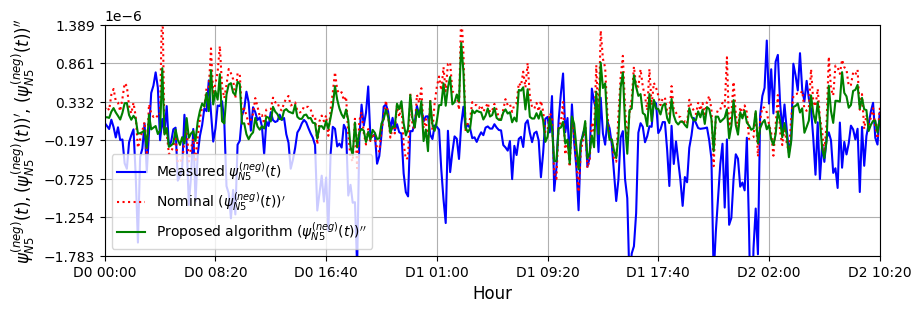

delta proposed: 4.611898071937986e-07
delta nominal: 5.289626422421139e-07
Ratio of difference m: 0.8718759518421818


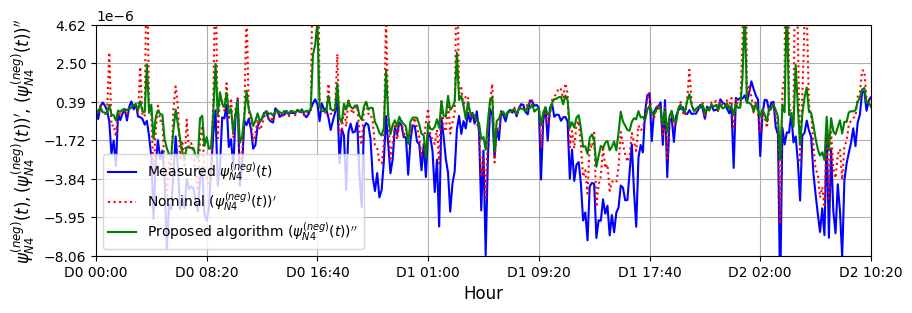

delta proposed: 1.508123835166433e-06
delta nominal: 1.53614918444411e-06
Ratio of difference m: 0.9817561018412293


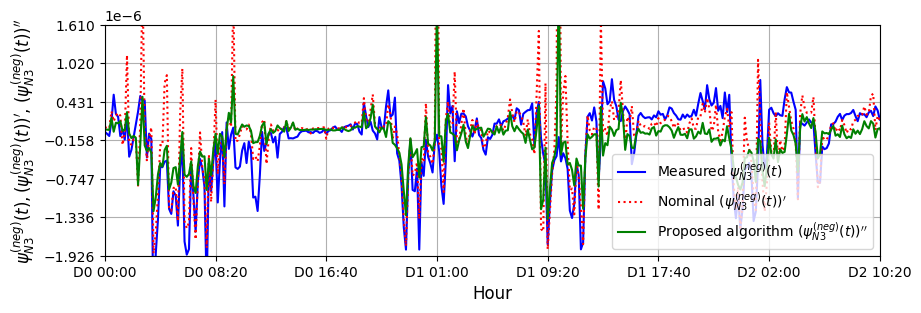

delta proposed: 3.221789115945619e-07
delta nominal: 3.2558316855168054e-07
Ratio of difference m: 0.9895441248628973


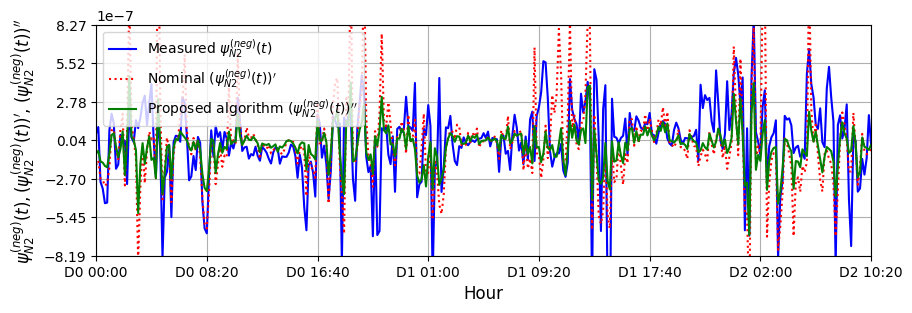

delta proposed: 1.6386300887391634e-07
delta nominal: 2.02269211108073e-07
Ratio of difference m: 0.8101233399598512
  nodeA nodeB   R [ohm]   X [ohm]  std_R [ohm]  std_X [ohm]         Z       error_Z  R_re [ohm]  X_re [ohm]   diff [%]
0   100   104  0.007443  0.008591     0.000024     0.000018  0.000129 -7.496871e-09       0.014       0.006  90.012960
1   100   103  0.037243  0.026766     0.000060     0.000033  0.001774 -1.554349e-01       0.078       0.024  63.777684
2   101   102  0.019541  0.015134     0.000038     0.000020  0.000611 -6.986317e-09       0.038       0.012  74.693183
3   100   101  0.012606  0.006760     0.000019     0.000010  0.000205 -1.770210e-07       0.021       0.016  97.724076


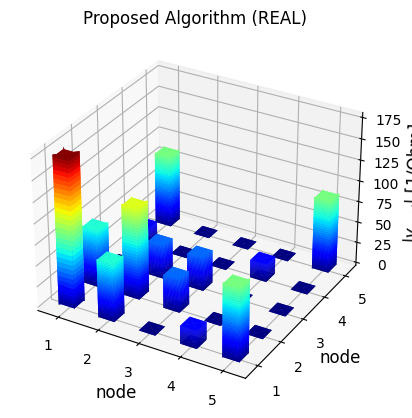

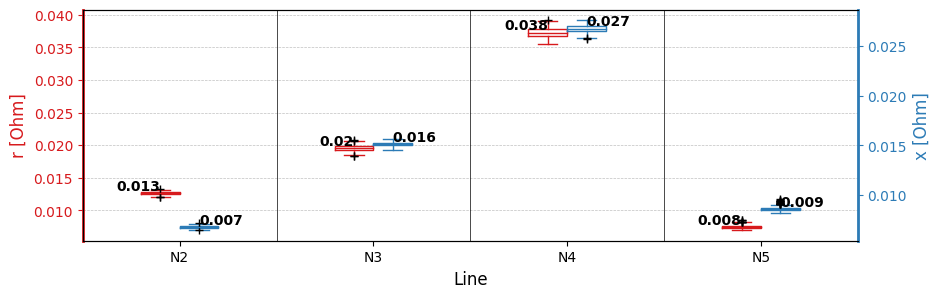

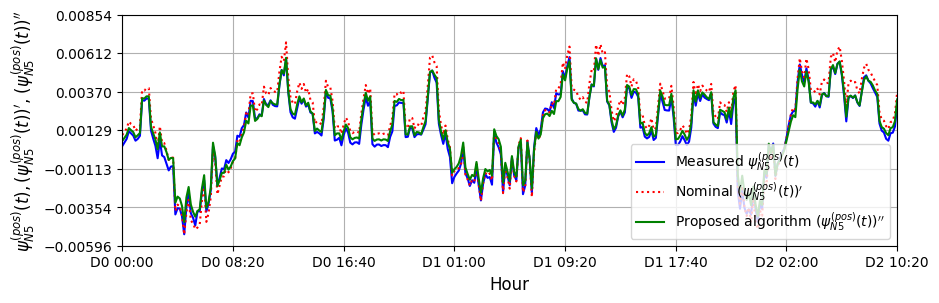

delta proposed: 0.0002760975686510562
delta nominal: 0.0005892141075008961
Ratio of difference m: 0.46858614743985283


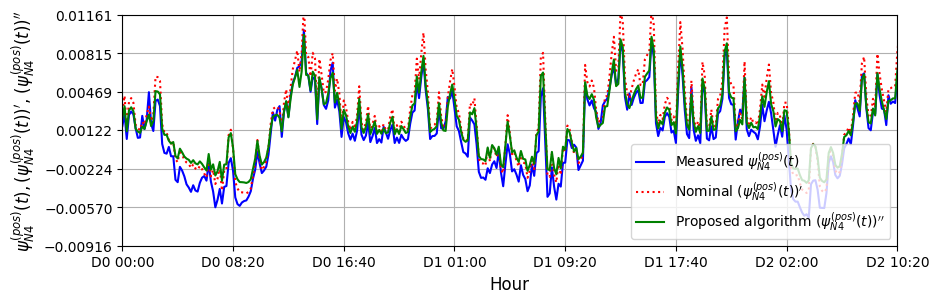

delta proposed: 0.0009411083927748562
delta nominal: 0.0013705696891066809
Ratio of difference m: 0.6866548999695581


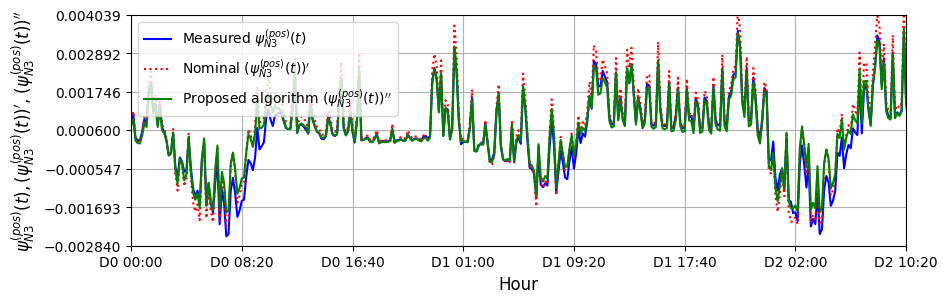

delta proposed: 0.0001589362920003732
delta nominal: 0.0002525652476862772
Ratio of difference m: 0.629288049153125


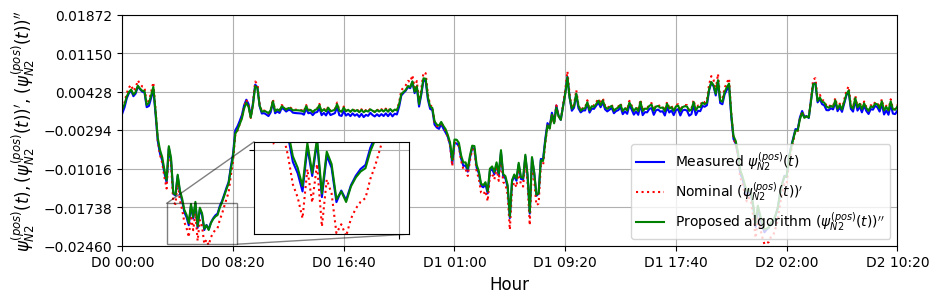

delta proposed: 0.00047224513708260014
delta nominal: 0.0009475536435240131
Ratio of difference m: 0.49838353776604144
  nodeA nodeB   R [ohm]   X [ohm]  std_R [ohm]  std_X [ohm]         Z       error_Z  R_re [ohm]  X_re [ohm]   diff [%]
0   100   104  0.011632  0.008718     0.000002     0.000013  0.000211 -1.054317e-06       0.014       0.006  62.215737
1   100   103  0.061531  0.022374     0.000031     0.000145  0.004287 -7.502969e-08       0.078       0.024  27.890149
2   101   102  0.030590  0.013639     0.000011     0.000034  0.001122 -2.578912e-07       0.038       0.012  33.157072
3   100   101  0.018523  0.012353     0.000001     0.000005  0.000496 -5.991486e-07       0.021       0.016  34.590401


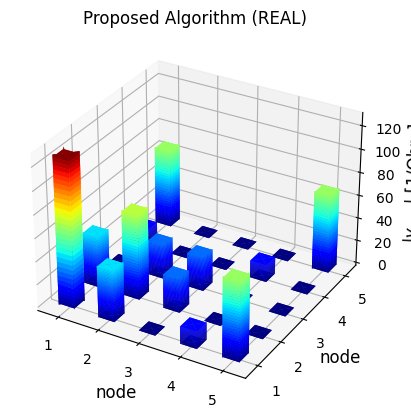

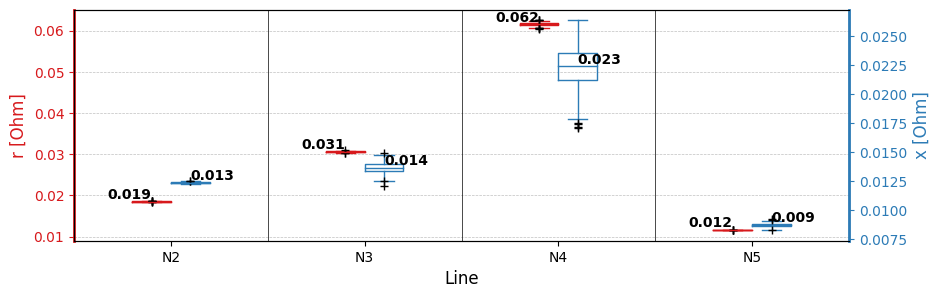

In [ ]:
warnings.filterwarnings("ignore")
df1 = {0: pd.DataFrame()}
databases2 = {
    0: {'name': 'La Chappelle', 'phase': ['L1', 'L2', 'L3']},
}
node_a_list = ['100','100','101','100']
node_b_list = ['104','103','102','101']
r_re2 = [0.014, 0.078, 0.038, 0.021]
x_re2 = [0.006, 0.024, 0.012, 0.016]
line_title = {'104': 'L4', '103':'L3', '102':'L2', '101':'L1'}
node_title = {'100': 'N1', '101': 'N2', '102': 'N3', '103': 'N4', '104': 'N5'}

# Read data
for l in range(0,len(node_a_list)):
    f_name_1 = cwd + '/data/' + "/Data_Chappelle_10Weeks/"+ node_a_list[l] +".csv"
    f_name_2 = cwd + '/data/' + "/Data_Chappelle_10Weeks/"+ node_b_list[l] +".csv"
    node_1 = pd.read_csv(f_name_1, sep=',')
    node_2 = pd.read_csv(f_name_2, sep=',')
    for ph in ['L1', 'L2', 'L3']:
        df1[0][node_a_list[l] + ' U ' + ph + ' [V]'] = np.asarray(node_1['Voltage ' + ph + ' avg [V]'][-4000::])
        df1[0][node_b_list[l] + ' U ' + ph + ' [V]'] = np.asarray(node_2['Voltage ' + ph + ' avg [V]'][-4000::])
        df1[0][node_b_list[l] + ' I ' + ph + ' [A]'] = 0
        df1[0][node_a_list[l] + ' P ' + ph + ' [W]'] = -np.asarray(node_1['P ' + ph + ' [kW]'][-4000::]*1000)
        df1[0][node_b_list[l] + ' P ' + ph + ' [W]'] = -np.asarray(node_2['P ' + ph + ' [kW]'][-4000::]*1000)
        df1[0][node_a_list[l] + ' Q ' + ph + ' [var]'] = -np.asarray(node_1['Q ' + ph + ' [kVar]'][-4000::]*1000)
        df1[0][node_b_list[l] + ' Q ' + ph + ' [var]'] = -np.asarray(node_2['Q ' + ph + ' [kVar]'][-4000::]*1000)

zbase = vbase ** 2 / sbase

for seq in ["zero", "neg", "pos"]:
    output = []
    r_all = []
    x_all = []
    for l0 in range(0, len(node_a_list)):
        node_a0, node_b0 = node_a_list[l0], node_b_list[l0]
        aggregated_data = aggregate_sequences(databases2, node_a0, node_b0, df1, vbase, sbase, seq=seq)
        r, x, std_r, std_x, z, error_z, r0, x0, z0  = ye.minimization_algorithm(aggregated_data, vbase, sbase, n_tests=500, n_sample=4000, seq=seq, fil_qu=4, fil_0=0.1,
                                                                                               epsilon=0 if seq=="pos" else 1e-3)

        output.append([node_a0, node_b0, r, x, std_r, std_x, z, error_z, r_re2[l0], x_re2[l0], np.abs(r - r_re2[l0]) * 100 / r_re2[l0] + np.abs(x - x_re2[l0]) * 100 / x_re2[l0]])
        r_all.extend([r0])
        x_all.extend([x0])

        cleaned_data = discard_data_points(line_nodes_data0=aggregated_data, fil_qu=2, fil_0=0.001)
        m1 = - cleaned_data["vj"] ** 2 + cleaned_data["vi"] ** 2
        m2 = r_re2[l0] * cleaned_data["pj"] * 2 / zbase + x_re2[l0] * cleaned_data["qj"]* 2 / zbase + (r_re2[l0] ** 2 + x_re2[l0] ** 2) * (cleaned_data["pj"] ** 2 + cleaned_data["qj"] ** 2) / (zbase ** 2 * (cleaned_data["vj"] ** 2))
        m3 = r * cleaned_data["pj"] * 2 / zbase + x * cleaned_data["qj"]* 2 / zbase + (r ** 2 + x ** 2) * (cleaned_data["pj"] ** 2 + cleaned_data["qj"] ** 2)/(zbase ** 2 * (cleaned_data["vj"] ** 2))

        dl = 400
        label_dl = 8
        x_axis = ["D" + str(int(i * 10 / (60 * 24))) + " " + "{:02d}".format(int(i * 10 / 60) - int(i * 10 / (60 * 24)) * 24) + ":" +"{:02d}".format(i * 10 - int(i * 10 / 60) * 60) for i in range(dl)]
        fig, ax = plt.subplots(figsize=(10, 3))
        plt.plot(x_axis, m1[:dl], "b")
        plt.plot(x_axis, m2[:dl], "r:")
        plt.plot(x_axis, m3[:dl], "g-")
        plt.ylim([(np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 - 3 * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3,
                  (np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 + 3 * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3])
        plt.xticks(np.arange(0, dl, dl / label_dl), [x_axis[int(dl * i / label_dl)] for i in range(label_dl)])
        plt.yticks([(np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 + i * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3 for i in [-3, -2, -1, 0, 1, 2, 3]])
        plt.legend(["Measured $\psi_{{{line}}}^{{({seq0})}}(t)$".format(line=node_title[node_b0], seq0=seq),
                    "Nominal $(\psi_{{{line}}}^{{({seq0})}}(t))'$".format(line=node_title[node_b0], seq0=seq),
                    "Proposed algorithm $(\psi_{{{line}}}^{{({seq0})}}(t))''$".format(line=node_title[node_b0], seq0=seq)
                    ])
        plt.style.use('default')
        plt.grid(True)
        plt.xlabel("Hour", fontsize=12)
        plt.ylabel("$\psi_{{{line}}}^{{({seq0})}}(t), $".format(line=node_title[node_b0], seq0=seq) +
                   "$(\psi_{{{line}}}^{{({seq0})}}(t))'$, ".format(line=node_title[node_b0], seq0=seq) +
                   "$(\psi_{{{line}}}^{{({seq0})}}(t))''$".format(line=node_title[node_b0], seq0=seq), fontsize=12)

        if (seq == "pos") & (l0 == 3):
            # inset axes....
            ax_ins = ax.inset_axes([0.17, 0.05, 0.2, 0.4])
            ax_ins.plot(x_axis, m1[:dl], "b")
            ax_ins.plot(x_axis, m2[:dl], "r:")
            ax_ins.plot(x_axis, m3[:dl], "g-")
            x1, x2, y1, y2 = x_axis[20], x_axis[2 + int(dl / label_dl)], (np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 - 2.96 * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3, (np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 - 1.9 * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3
            ax_ins.set_xticks(np.arange(0, dl, dl / label_dl), [])
            ax_ins.set_yticks([(np.mean(m1[:dl]) + np.mean(m1[:dl]) + np.mean(m1[:dl])) / 3 + i * (np.std(m1[:dl]) + np.std(m1[:dl]) + np.std(m1[:dl])) / 3 for i in [-3, -2, -1, 0, 1, 2, 3]])
            ax_ins.set_xlim(x1, x2)
            ax_ins.set_ylim(y1, y2)
            ax_ins.set_yticklabels([])
            ax.indicate_inset_zoom(ax_ins, edgecolor="black")
            ax_ins.grid(True)
        plt.xlim([x_axis[0], x_axis[int(dl * (label_dl - 1) / label_dl)]])
        plt.savefig("figures/Ms_" + str(l0) + "_" + seq + ".pdf", pad_inches = 0, bbox_inches='tight')
        plt.show()
        print("delta proposed: " + str(np.mean(np.abs(m1[:dl] - m3[:dl]))))
        print("delta nominal: " + str(np.mean(np.abs(m1[:dl] - m2[:dl]))))
        print("Ratio of difference m: " + str(np.mean(np.abs(m1[:dl] - m3[:dl])) / np.mean(np.abs(m1[:dl] - m2[:dl]))))

    result = pd.DataFrame(output, columns=['nodeA', 'nodeB', 'R [ohm]', 'X [ohm]', 'std_R [ohm]', 'std_X [ohm]', 'Z', 'error_Z', 'R_re [ohm]', 'X_re [ohm]', 'diff [%]'])
    print(result.to_string())

    plt.style.use('default')
    _, ybus, _ = ybus_calculation(node_a_list, node_b_list, result["R [ohm]"].tolist(), result["X [ohm]"].tolist())
    data = np.abs(ybus)
    x = np.arange(1, data.shape[1] + 1)
    y = np.arange(1, data.shape[0] + 1)
    x_mesh, y_mesh = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    make_bars(ax, x_mesh, y_mesh, data, width=0.2, cmap=mpl.colormaps["jet"], max_h=max_h)
    ax.set_xlabel("node", fontsize=12)
    ax.set_ylabel("node", fontsize=12)
    ax.set_zlabel("$|y_{n,n'}|$ [1/Ohm]", fontsize=12)
    ax.set_zlim(0, np.max([max_h, np.max(data)]))
    plt.title("Proposed Algorithm (REAL)", fontsize=12)
    fig.savefig("figures/minimization_algorithm_real_" + seq + ".pdf", bbox_inches=mpl.transforms.Bbox.from_bounds(1.6, 0.45, 4, 4))


    plt.style.use("default")
    fig, ax1 = plt.subplots(figsize=(10, 3))
    bpl1 = ax1.boxplot([[zbase * x for x in x2] for x2 in r_all[::-1]], positions=[i-0.1 for i in range(1,5)], sym='+', widths=0.2, whis=1.5)
    for i, j in zip([i-0.1 for i in range(1,5)], [x for x in result["R [ohm]"].tolist()[::-1]]):
        ax1.text(i, j, str(math.ceil(j*1000)/1000), ha='right', va='bottom', weight="bold")
    ax2 = ax1.twinx()
    bpl2 = ax2.boxplot([[zbase * x for x in x2] for x2 in x_all[::-1]], positions=[i+0.1 for i in range(1,5)], sym='+', widths=0.2, whis=1.5)
    for i, j in zip([i+0.1 for i in range(1,5)], [x for x in result["X [ohm]"].tolist()[::-1]]):
        ax2.text(i, j, str(math.ceil(j*1000)/1000), ha='left', va='bottom', weight="bold")
    set_box_color(bpl1, '#D7191C')
    set_box_color(bpl2, '#2C7BB6')
    ax1.spines["left"].set_color('#D7191C')
    ax1.spines["left"].set_linewidth(2)
    ax2.spines["right"].set_color('#2C7BB6')
    ax2.spines["right"].set_linewidth(2)
    ax1.tick_params(axis="y", colors="#D7191C")
    ax2.tick_params(axis="y", colors="#2C7BB6")
    ax1.set_xticks([1, 2, 3, 4], list(node_title.values())[1:])
    ax1.grid(color = 'silver', which="both", axis="y", linestyle = '--', linewidth = 0.5)
    for i in [1.5, 2.5, 3.5]:
        ax1.axvline(i, color = 'black', linestyle = '-', linewidth = 0.5)
    ax1.set_xlim([0.5, 4.5])
    ax1.set_ylabel("r [Ohm]", fontsize=12, color="#D7191C")
    ax2.set_ylabel("x [Ohm]", fontsize=12, color="#2C7BB6")
    ax1.set_xlabel("Line", fontsize=12)
    plt.savefig("figures/Rs_" + seq + ".pdf", pad_inches = 0, bbox_inches='tight')
